# Lecture 4. CNN build
* Ref. 최건호, 파이토치 첫걸음, 한빛미디어 ([link](https://drive.google.com/drive/folders/12zphz36T6gEJac6WScnvRN27-f1tfHO1))

## 1. 인공신경망 (Deep Neural Network; DNN)
* 2장의 선형회귀모델과 달리, 비선형인 2차함수에 대한 회귀모델을 딥러닝으로 구현해보자!
* y = x<sup>2</sup>+3

### 1.1. 라이브러리 및 데이터 만들기 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# GPU에서 학습을 위해 GPU check
print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

사용 가능한 GPU가 존재하는가? (True or False):  True
사용 가능한 GPU의 수는 4 개 입니다.
GPU 각각의 이름은 아래와 같습니다.
GPU 0: NVIDIA GeForce GTX TITAN X
GPU 1: NVIDIA GeForce GTX TITAN X
GPU 2: NVIDIA GeForce GTX TITAN X
GPU 3: NVIDIA GeForce GTX TITAN X


In [3]:
# 데이터 생성
num_data = 1000

noise = init.normal_(torch.FloatTensor(num_data,1),std=3)
x = init.uniform_(torch.Tensor(num_data,1),-15,15)
y = (x**2) + 3 
y_noise = y + noise

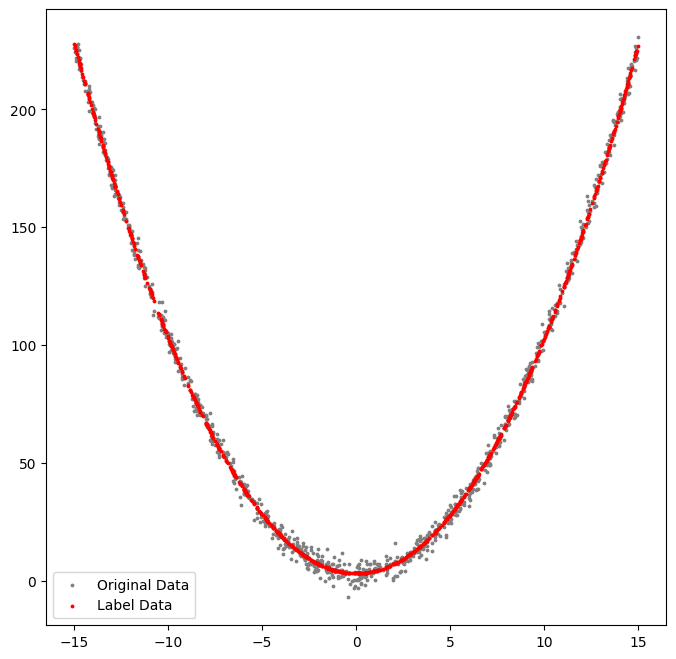

In [4]:
# 데이터 시각화
plt.figure(figsize=(8,8))
plt.scatter(x.numpy(), y_noise.numpy(), s=3, c='gray', label='Original Data') # 학습시킬 실제 데이터 분포
plt.scatter(x.numpy(), y.numpy(), s=3, c='red', label='Label Data') # 정답 분포
plt.legend()

### 1.2. 모델 생성 및 학습

In [5]:
# 3장의 예시처럼 하나의 값이 들어가서 하나의 값이 나오기 때문에 모델의 처음과 끝 특성의 개수는 1개입니다.

# https://pytorch.org/docs/stable/nn.html?highlight=sequential
# torch.nn.Sequential
# Sequential 모듈은 다양한 모듈을 담을 수 있는 일종의 리스트라고 보면 됩니다.
# Sequential 에 정의된 순서대로 연산이 진행되며, 많은 연산을 묶어서 한번에 관리할 수 있어서 편리합니다.

# 아래 코드는 특성의 개수가 1 -> 6 -> 10 -> 6 -> 1개로 변하는 인공신경망입니다. 
# 또한 선형변환 이후 활성화 함수를 넣어 비선형성이 생기도록 했습니다.

model = nn.Sequential(
          nn.Linear(1,6),
          nn.ReLU(),
          nn.Linear(6,10),
          nn.ReLU(),
          nn.Linear(10,6),
          nn.ReLU(),
          nn.Linear(6,1),
      )

loss_func = nn.L1Loss() # 손실함수로는 L1(절대값의 평균) loss 사용
optimizer = optim.SGD(model.parameters(),lr=0.0002) # 옵티마이저로는 SGD 사용

In [6]:
num_epoch = 10000 # 학습시킬 epoch 수
device = 'cuda:0' # 학습시킬 gpu
loss_array = []
pbar = tqdm(total=num_epoch) # tqdm으로 학습 진행도 확인 가능
for i in range(num_epoch): 
    x.to(device)
    y_noise.to(device)
    optimizer.zero_grad()
    output = model(x)
    
    loss = loss_func(output,y_noise)
    loss.backward() # 역전파 손실 연산
    optimizer.step() # 옵티마이저로 가중치 업데이트
    
    pbar.set_description(f"Processing({i+1}/{num_epoch}): loss={loss.data}")
    pbar.update(1)
    loss_array.append(loss.detach().numpy()) # 손실값의 데이터만 numpy로 보냄
pbar.close()

Processing(10000/10000): loss=79.2270736694336: 100%|██████████| 10000/10000 [00:18<00:00, 538.95it/s]


### 1.3. 결과 확인

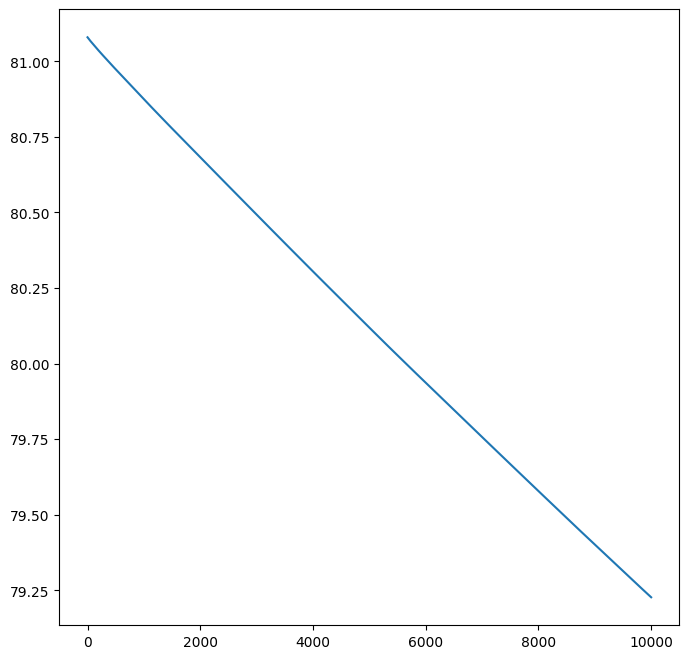

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(loss_array)
# plt.show()

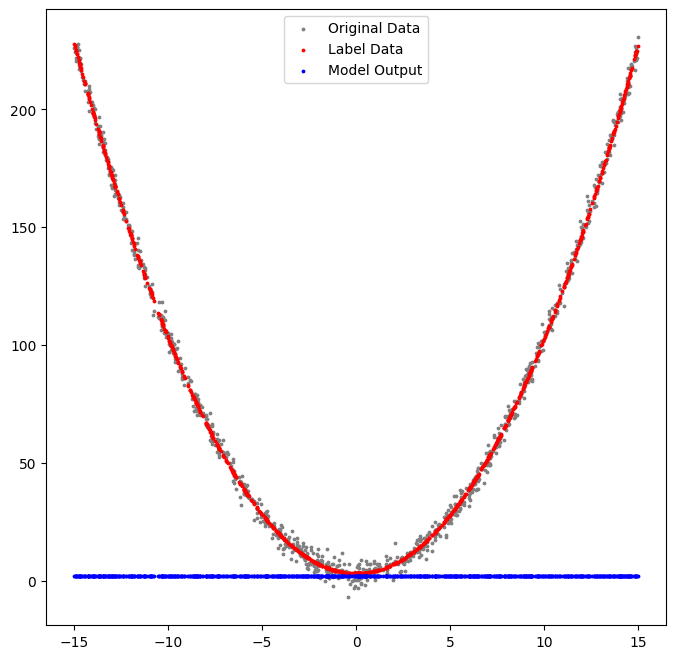

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(x.detach().numpy(),y_noise, s=3, c='grey', label="Original Data")
plt.scatter(x.detach().numpy(),y, s=3, c='red', label="Label Data")
plt.scatter(x.detach().numpy(),output.detach().numpy(), s=3, c='blue',label="Model Output")
plt.legend()

## 2. 합성곱 신경망 (Convolutional Neural Network; CNN)

* MNIST 데이터 사용
* 기초적인 합성곱 신경망 실습

In [9]:
# Colab에서 실행시 파이토치 설치
#!pip install torch torchvision

### 2.1. 환경 세팅

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다. 
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(torch.__version__)

2.0.0+cu117


### 2.2. 데이터셋

In [11]:
# https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=mnist#torchvision.datasets.MNIST
# 첫번째 인자 root는 데이터를 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미합니다.
data_path = '/home/student/Datasets/jhjeong/Test/' # 자신의 환경에 맞게 설정!

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있습니다. 
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미합니다.
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줍니다.

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
mnist_train = dset.MNIST(root=data_path, train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root=data_path, train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

* MNIST Dataset 구조: (frame1(image, label), frame2(image, label), ..., frame60000(image, label))
* index 순서 : mnist_train[frame_index(0~60000)][0(image) or 1(label)]

In [12]:
# 데이터셋 확인 (torch tensor)
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


torch.Size([1, 28, 28])
5


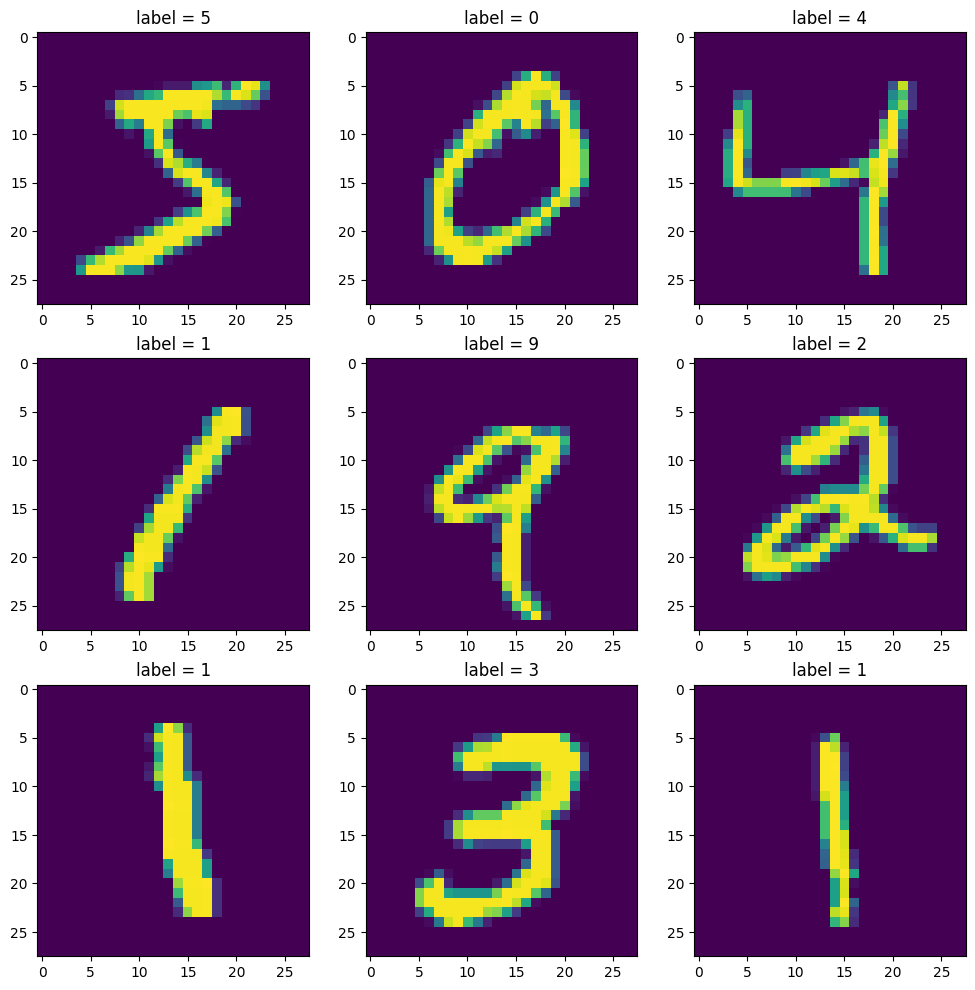

In [13]:
print(mnist_train[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(mnist_train[0][1]) # 0번째 프레임의 레이블(정답) 출력
plt.figure(figsize=(12,12))
for i in range(3*3): # 9개의 데이터 추가 확인
    plt.subplot(3,3,i+1)
    plt.imshow(np.moveaxis(mnist_train[i][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label = {mnist_train[i][1]}')

* DataLoader 설정
    - batch_size = 배치 사이즈
    - shuffle = 섞을지 여부
    - num_workers = 데이터를 묶을때 사용할 프로세스 수
    - drop_last = 묶고 남은 데이터를 버릴지 여부

In [14]:
batch_size = 256

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 2.3. 모델 만들기

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),                                                          # 필터의 개수는 1개(흑백이미지)에서 16개로 늘어나도록 임의로 설정했습니다. 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다.
        out = out.view(batch_size,-1)                                           # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 바꿔줍니다. 2차원 이미지를 1차원으로 펴주는 과정
                                                                                # ex) 2x3 형태였던 텐서를 .view(1,-1) 해주면 1x6의 형태로 바뀝니다. .view(3,-1)이면 3x2로 바뀜.
                                                                                # 만약 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 납니다.
        out = self.fc_layer(out)
        return out

In [41]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = CNN().to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


### 2.4. 모델 학습

In [42]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metric
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # Epoch result 
        train_loss += loss.item()
        train_acc += correct

        # Traing Process check
        loss, current = loss.item(), (batch + 1) * len(x)
        acc = correct/len(x)
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, acc = {100*acc:>0.1f}%")
        pbar.update(1)
    pbar.close()
    # epoch 
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

In [43]:
# 검증 모듈
def test(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc /= size
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_acc: {(100*test_acc):>0.1f}%")
    return test_loss, test_acc

In [44]:
num_epoch = 10

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for t in range(num_epoch):
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(test_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {100*train_acc:>0.1f}, val_loss = {val_loss:5>f}, val_acc = {100*val_acc:>0.1f}')

 - Batch Training[1](59904/60000): loss = 0.288665, acc = 90.2%: 100%|██████████| 234/234 [00:04<00:00, 56.22it/s]


# Training[1/10]: loss = 0.765664, acc = 79.1, val_loss = 0.257335, val_acc = 92.0


 - Batch Training[2](59904/60000): loss = 0.161809, acc = 95.7%: 100%|██████████| 234/234 [00:04<00:00, 55.87it/s]


# Training[2/10]: loss = 0.208253, acc = 93.5, val_loss = 0.135703, val_acc = 95.9


 - Batch Training[3](59904/60000): loss = 0.115143, acc = 95.7%: 100%|██████████| 234/234 [00:04<00:00, 54.96it/s]


# Training[3/10]: loss = 0.126880, acc = 96.0, val_loss = 0.094349, val_acc = 97.0


 - Batch Training[4](59904/60000): loss = 0.100973, acc = 98.0%: 100%|██████████| 234/234 [00:04<00:00, 57.34it/s]


# Training[4/10]: loss = 0.096845, acc = 96.9, val_loss = 0.074294, val_acc = 97.5


 - Batch Training[5](59904/60000): loss = 0.101643, acc = 96.9%: 100%|██████████| 234/234 [00:04<00:00, 56.86it/s]


# Training[5/10]: loss = 0.077230, acc = 97.5, val_loss = 0.062739, val_acc = 97.9


 - Batch Training[6](59904/60000): loss = 0.033945, acc = 98.8%: 100%|██████████| 234/234 [00:04<00:00, 56.87it/s] 


# Training[6/10]: loss = 0.066622, acc = 97.8, val_loss = 0.052791, val_acc = 98.2


 - Batch Training[7](59904/60000): loss = 0.103790, acc = 97.7%: 100%|██████████| 234/234 [00:04<00:00, 56.71it/s] 


# Training[7/10]: loss = 0.058845, acc = 98.1, val_loss = 0.048191, val_acc = 98.3


 - Batch Training[8](59904/60000): loss = 0.101641, acc = 96.5%: 100%|██████████| 234/234 [00:04<00:00, 55.12it/s] 


# Training[8/10]: loss = 0.051627, acc = 98.3, val_loss = 0.044355, val_acc = 98.4


 - Batch Training[9](59904/60000): loss = 0.047013, acc = 98.4%: 100%|██████████| 234/234 [00:04<00:00, 54.86it/s] 


# Training[9/10]: loss = 0.047784, acc = 98.4, val_loss = 0.047168, val_acc = 98.3


 - Batch Training[10](59904/60000): loss = 0.052728, acc = 97.3%: 100%|██████████| 234/234 [00:04<00:00, 57.54it/s] 


# Training[10/10]: loss = 0.044372, acc = 98.5, val_loss = 0.042765, val_acc = 98.5


### 2.5. 결과 분석

In [46]:
for key in history.keys():
    print(key, history[key])

loss [0.7656643468982134, 0.2082528007399832, 0.12688033354397005, 0.09684524874592948, 0.07722994239411803, 0.06662219163412467, 0.05884527142804403, 0.05162671775931222, 0.04778396929654046, 0.04437177409776128]
val_loss [0.2573351787928587, 0.135703176439095, 0.09434937674982044, 0.0742935521247534, 0.06273908905374508, 0.052791078843606204, 0.04819112105104022, 0.0443547442346477, 0.047167679004651755, 0.04276471184447217]
acc [0.7914, 0.9345166666666667, 0.96035, 0.9689833333333333, 0.9750833333333333, 0.9776666666666667, 0.9808166666666667, 0.9830166666666666, 0.9836166666666667, 0.9846]
val_acc [0.9203, 0.9588, 0.9705, 0.9749, 0.9792, 0.9821, 0.983, 0.9839, 0.9828, 0.985]


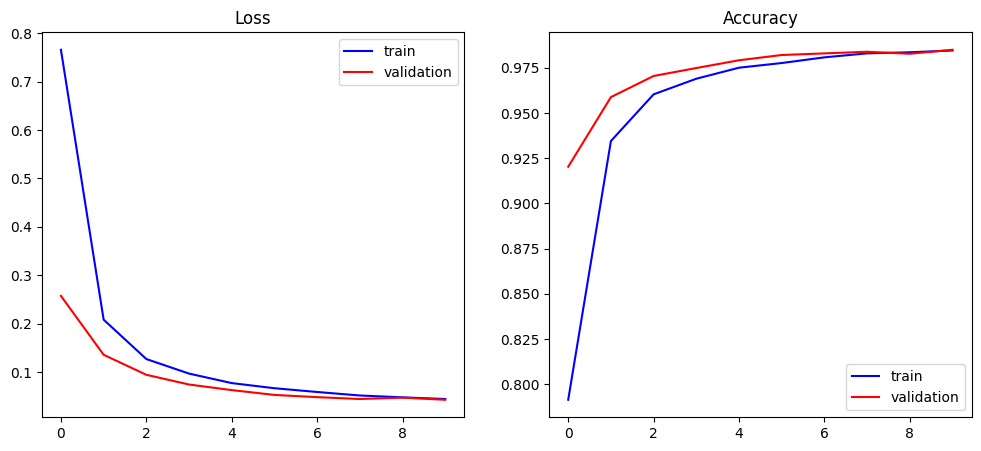

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['acc'], c='b', label='train')
plt.plot(history['val_acc'], c='r', label='validation')
plt.legend()

In [71]:
pred_dic = {'prob': [], 'pred': []}
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            # probs -= np.min(probs)
            # probs /= np.sum(probs)
            pred_dic['prob'].append(probs)
            pred_dic['pred'].append(pred[i].argmax().item())
print(pred_dic['pred'])
print(pred_dic['prob'][0])
print(len(pred_dic['pred']))

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 3, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 7, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

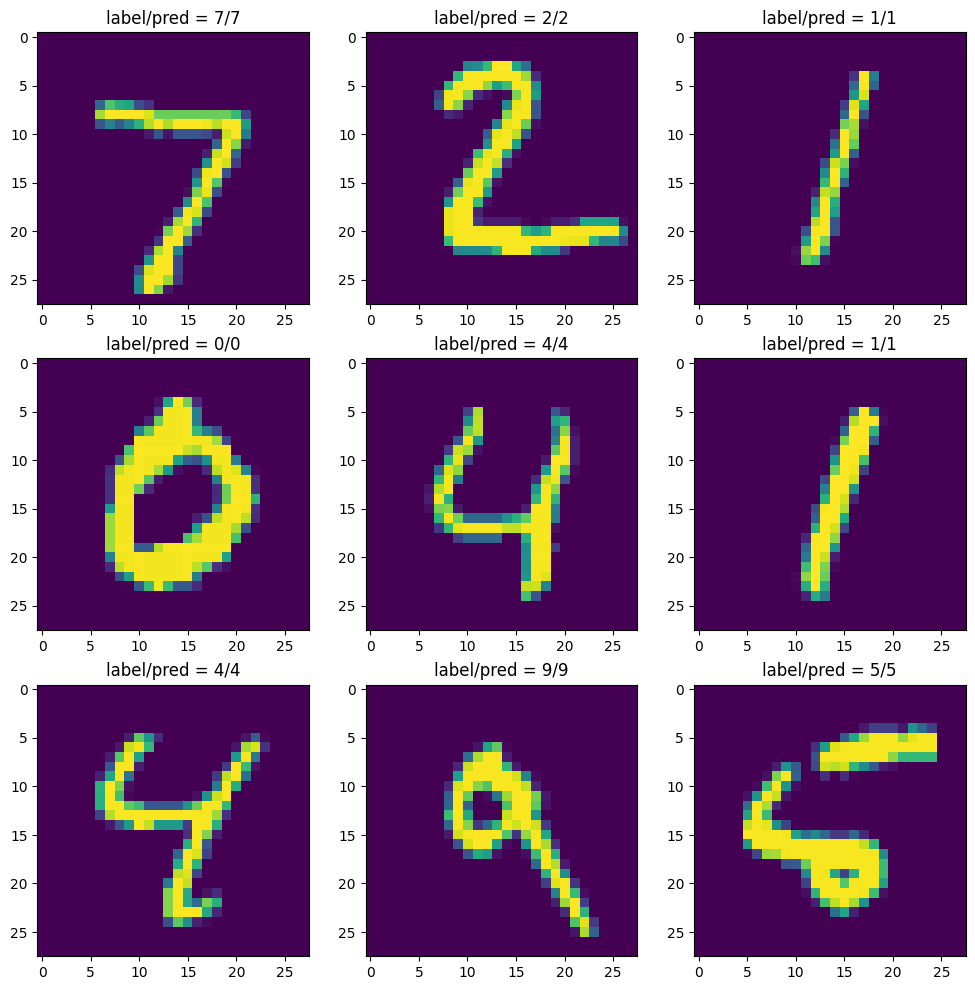

In [72]:
plt.figure(figsize=(12,12))
for i in range(9):
    img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
    pred = pred_dic['pred'][i]
    # score = pred_dic['prob'][i][pred]
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')

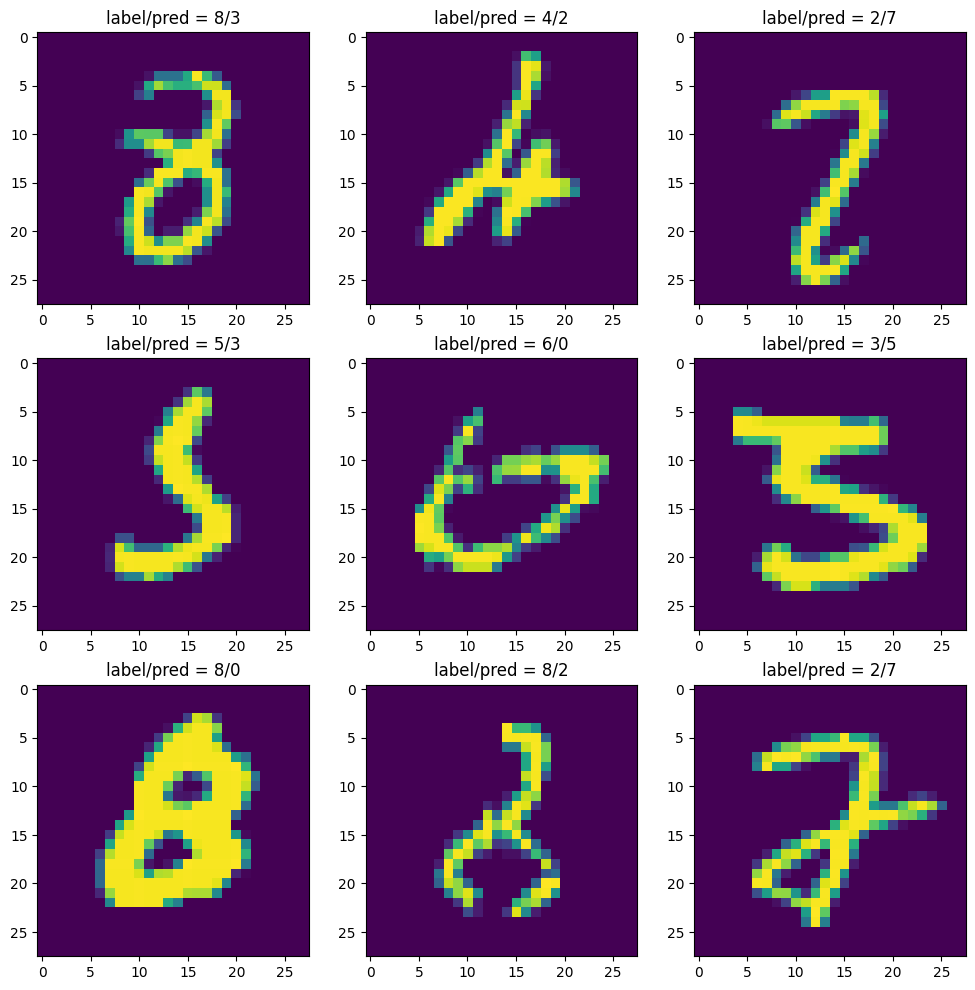

In [73]:
# false case
plt.figure(figsize=(12,12))
n = 0
for i in range(len(pred_dic['pred'])):
    pred = pred_dic['pred'][i]
    lab = mnist_test[i][1]
    if pred != lab and n < 9:
        n += 1
        img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
        plt.subplot(3,3,n)
        plt.imshow(img)
        plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')